---
# [E-03] make a lyricist

## 01. 데이터 로드


In [66]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


---
## 02. 데이터 전처리
학습에 용이하도록 데이터를 삭제 및 수정

#### - 문장 다듬기

     1. 소문자로 바꾸고, 양쪽 공백을 지우기
     2. 특수문자 양쪽에 공백을 넣기
     3. 여러개의 공백은 하나의 공백으로 바꾸기
     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
     5. 다시 양쪽 공백을 지우기
     6. 문장 시작에는 <start>, 끝에는 <end>를 추가
     
#### - 문장 길이 제한     

In [67]:

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [68]:
corpus2 = []

for sentence in raw_corpus:
    # 불필요한 줄 제거
    if len(sentence) == 0: continue
#     if sentence[-1] == ":": continue
    preprocessed_sentence = preprocess_sentence(sentence)
    # 정제후 단어의 개수가 13개를 넘는 문장 제외 (<start>, <end> 제외)
    if not ( preprocessed_sentence.count(' ')+1 <= 15) : continue
#     if preprocessed_sentence.count(' ')+1 <= 4 : continue    

    
    corpus2.append(preprocessed_sentence)
        

corpus2[:10]


['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [69]:
print(corpus2[2].count(' '))

13


## 03. 데이터 토큰화
- 12000단어 짜리 사전을 만든다고 생각하자.
- 각 단어 별로 숫자가 매겨진다.
- 사전 속 없는 단어는 <unk> 로 출력된다.


In [70]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만든다.
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus2)

[[  2  50   4 ...   0   0   0]
 [  2  15   1 ...   0   0   0]
 [  2  33   7 ...  46   3   0]
 ...
 [  2   4 117 ...   0   0   0]
 [  2 258 195 ...  12   3   0]
 [  2   7  34 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fec34dee040>


다음와 같이 숫자별로 단어들이 등록된 것을 확인 할 수 있다.

In [71]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break
        

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 04. 데이터셋 만들기
입력과 출력에 대한 데이터 셋을 만들어준다. 이번에는 각각 source와 target이다.
아래와 같은 형태를 만들어준다고 생각하면 이해가 편하다.

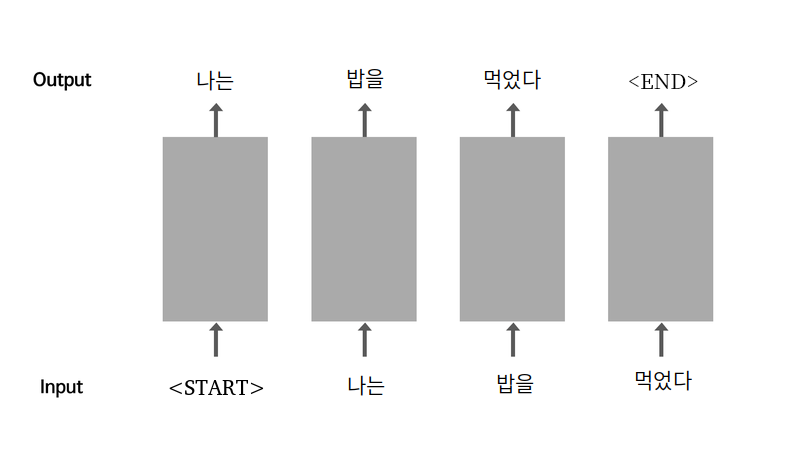

In [72]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  50   4  95 303  62  53   9 946   1   3   0   0   0]
[ 50   4  95 303  62  53   9 946   1   3   0   0   0   0]


In [74]:
from sklearn.model_selection import train_test_split
    
    # 8:2로 validation set 만들어줌.
enc_train, enc_val, dec_train, dec_val = train_test_split(
    src_input, tgt_input, test_size=0.2, random_state=7
)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)


In [77]:
TRAIN_BUFFER_SIZE = len(enc_train)
VAL_BUFFER_SIZE = len(enc_val)

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 128

# steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

trainset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))    # Train numpy를 dataset형식으로 변환
trainset = trainset.shuffle(TRAIN_BUFFER_SIZE)                           # Train dataset 섞기
trainset = trainset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)        # Train dataset의 배치사이즈 설정
 
testset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))       # Test numpy를 dataset형식으로 변환
testset = testset.shuffle(VAL_BUFFER_SIZE)                              # Test dataset 섞기
testset = testset.batch(VAL_BATCH_SIZE, drop_remainder=True)           # Test dataset의 배치사이즈 설정


## 05. 모델 설계 및 학습
- Embedding은 tokenize한 정보들을 벡터로 변환해주는 역할.
- hidden_size는 노드 수.

In [78]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)     # 단어사전에 의해 변환된 숫자를 벡터로 변환
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)     # LSMT Layer 
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)     # LSMT Layer
        self.linear = tf.keras.layers.Dense(vocab_size)                            # 출력 및 단어 예측을 위한 Fully-Connected Layer
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model_lstm = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)


#Optimizer , Loss

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model_lstm.compile(loss=loss, optimizer=optimizer)
model_lstm.fit(trainset, epochs=10, validation_data=testset)

Epoch 1/10
244/244 [==============================] - 195s 730ms/step - loss: 2.7572 - val_loss: 2.4163
Epoch 2/10
244/244 [==============================] - 180s 739ms/step - loss: 2.2992 - val_loss: 2.2222
Epoch 3/10
244/244 [==============================] - 181s 741ms/step - loss: 2.1107 - val_loss: 2.0943
Epoch 4/10
244/244 [==============================] - 181s 741ms/step - loss: 1.9206 - val_loss: 1.9851
Epoch 5/10
244/244 [==============================] - 181s 742ms/step - loss: 1.7068 - val_loss: 1.8930
Epoch 6/10
244/244 [==============================] - 181s 742ms/step - loss: 1.4817 - val_loss: 1.8236
Epoch 7/10
244/244 [==============================] - 181s 742ms/step - loss: 1.2802 - val_loss: 1.7817
Epoch 8/10
244/244 [==============================] - 181s 742ms/step - loss: 1.1293 - val_loss: 1.7725
Epoch 9/10
244/244 [==============================] - 181s 742ms/step - loss: 1.0393 - val_loss: 1.7830
Epoch 10/10
244/244 [==============================] - 181s 741m

## 06. 학습 결과
- 문장 생성 결과(i love, hey boy, sunday, what should)


In [81]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [82]:
print(generate_text(model_lstm, tokenizer, init_sentence="<start> i love", max_len=20))
print(generate_text(model_lstm, tokenizer, init_sentence="<start> hey boy", max_len=20))
print(generate_text(model_lstm, tokenizer, init_sentence="<start> sunday", max_len=20))
print(generate_text(model_lstm, tokenizer, init_sentence="<start> what should", max_len=20))

<start> i love you <end> 
<start> hey boy , i really wanna be with you <end> 
<start> sunday , is when i get my <unk> <end> 
<start> what should i do , babe ? <end> 


## 07. 회고

#### 모델을 다양하게 써보지 못한 점이 아쉽다. 하지만 우수 노드를 참고해보니 학습의 속도와 정확도는 좋지만 막상 출력하는 결과물은 드라마틱하지 않은 듯 하다. 그만큼 자연어 처리는 분류와 회귀 문제 또는 CV랑은 전혀 다른 영역이란 것을 느꼈다. 아마 Overfitting에 상당히 예민하게 반응하는 분야라고 예상된다.
- NLP에서는 어떤 전처리 과정들이 있는지 좀 더 찾아볼 필요가 있다.
- Loss값이 모델의 성능과 큰 영향이 있는 것은 아닌 것 같다. 이 부분에 대한 이유들도 찾아보자.
